In [1]:
%load_ext autoreload
%autoreload 2
import os
os.chdir('/home/jorge/thesis')

from pytorch3d.io import load_objs_as_meshes
import torch
from pytorch3d.renderer import FoVPerspectiveCameras
from text3d2video.util import read_obj_uvs
from text3d2video.utilities.mesh_processing import normalize_meshes

torch.set_grad_enabled(False)

# read mesh
mesh_path = "data/meshes/mixamo-human.obj"

device = "cuda"
meshes = load_objs_as_meshes([mesh_path], device=device)
meshes = normalize_meshes(meshes)
verts_uvs, faces_uvs = read_obj_uvs(mesh_path)

print('verts', meshes.verts_list()[0].shape)
print('faces', meshes.faces_list()[0].shape)

/home/jorge/miniconda3/envs/thesis4/lib/python3.9/site-packages/pytorch3d/io/obj_io.py:546: UserWarning: No mtl file provided
  warnings.warn("No mtl file provided")


verts torch.Size([14442, 3])
faces torch.Size([28880, 3])


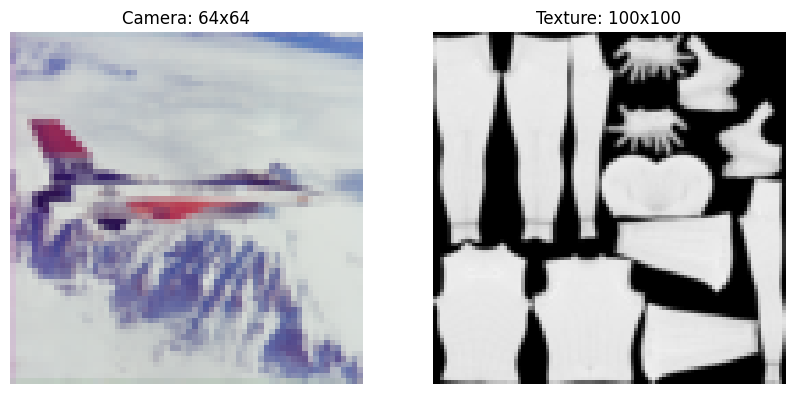

In [2]:
from matplotlib import pyplot as plt
import torch
from torchvision.io import read_image
import torchvision.transforms.functional as TF

TEXTURE_RES = 100
CAMERA_RES = 64

texture_image = read_image("data/meshes/mixamo-human_uvs.png") / 255
texture_image = TF.resize(texture_image, (TEXTURE_RES, TEXTURE_RES))
texture_image = texture_image[0:3, :, :]
texture_image = texture_image.permute(1, 2, 0).to(device)

camera_image = read_image("data/images/airplane.png") / 255
camera_image = TF.resize(camera_image, (CAMERA_RES, CAMERA_RES))
camera_image = camera_image.permute(1, 2, 0).to(device)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

ax_tex = axs[1]
ax_cam = axs[0]

ax_tex.set_title(f"Texture: {TEXTURE_RES}x{TEXTURE_RES}")
ax_tex.imshow(texture_image.cpu().numpy())

ax_cam.set_title(f"Camera: {CAMERA_RES}x{CAMERA_RES}")
ax_cam.imshow(camera_image.cpu().numpy())

for ax in axs:
    ax.axis("off")

(-0.5, 511.5, 511.5, -0.5)

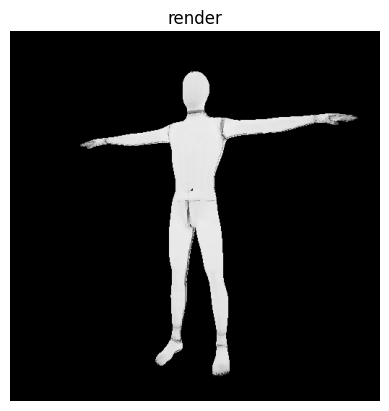

In [3]:
from text3d2video.rendering import make_mesh_renderer, make_repeated_uv_texture
from text3d2video.utilities.camera_placement import turntable_extrinsics

R, T = turntable_extrinsics(angles=20, dists=1)
cam = FoVPerspectiveCameras(R=R, T=T, device=device, fov=65)

meshes.textures = make_repeated_uv_texture(
    texture_image, faces_uvs, verts_uvs, sampling_mode="nearest"
)
renderer = make_mesh_renderer()
frames = renderer(meshes, cameras=cam)

plt.title("render")
plt.imshow(TF.to_pil_image(frames[0].cpu()))
plt.axis("off")

In [4]:
from text3d2video.backprojection import project_visible_texels_to_camera

texel_projection = project_visible_texels_to_camera(
    meshes, cam, verts_uvs, faces_uvs, raster_res=2000, texture_res=TEXTURE_RES
)
torch.cuda.empty_cache()

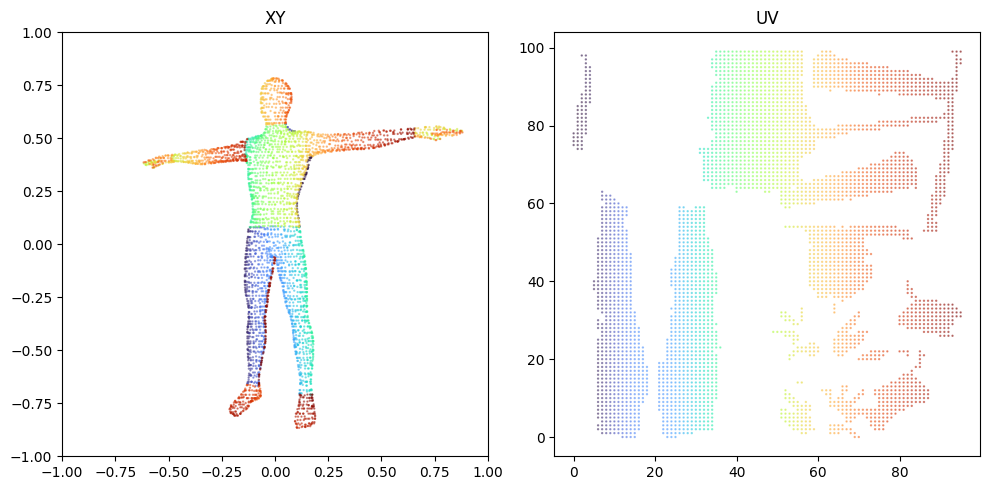

In [5]:
from matplotlib.axes import Axes
from text3d2video.backprojection import TexelProjection


def plot_projection(
    texel_projection: TexelProjection,
    ax_xy: Axes,
    ax_uv: Axes,
    xy_image = None,
    uv_image = None,
    cmap="turbo",
    s=0.5,
    alpha=0.5,
):
    indices = torch.arange(0, texel_projection.xys.shape[0], device=device)

    if xy_image is not None:
        ax_xy.imshow(xy_image, extent=(-1, 1, -1, 1))

    ax_xy.set_xlim(-1, 1)
    ax_xy.set_ylim(-1, 1)
    ax_xy.set_title("XY")

    ax_xy.scatter(
        texel_projection.xys[:, 0].cpu(),
        texel_projection.xys[:, 1].cpu(),
        s=s,
        c=indices.cpu(),
        cmap=cmap,
        alpha=alpha,
    )

    if uv_image is not None:
        ax_uv.imshow(uv_image)

    ax_uv.scatter(
        texel_projection.uvs[:, 0].cpu(),
        texel_projection.uvs[:, 1].cpu(),
        s=s,
        c=indices.cpu(),
        cmap=cmap,
        alpha=alpha,
    )
    ax_uv.set_title("UV")

    plt.tight_layout()

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
ax_xy = axs[0]
ax_uv = axs[1]
plot_projection(texel_projection, ax_xy, ax_uv)

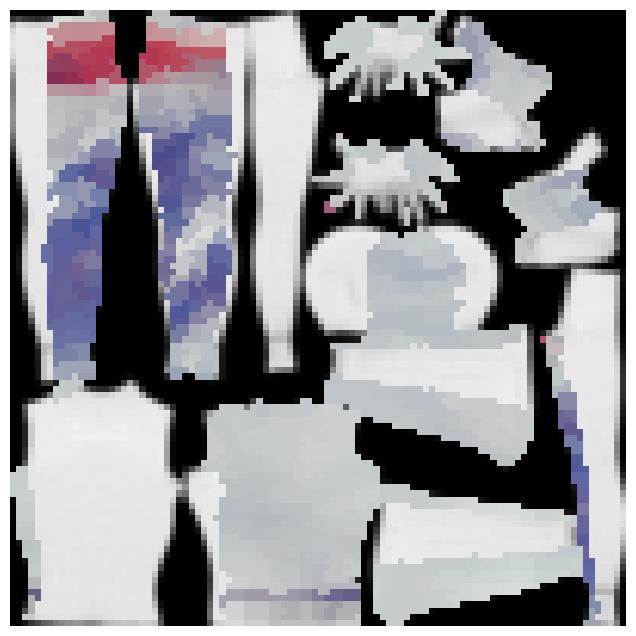

<Figure size 640x480 with 0 Axes>

In [6]:
from text3d2video.util import sample_feature_map_ndc
from text3d2video.utilities.ipython_utils import display_ims

camera_fmap = camera_image.permute(2, 0, 1)

xy_coords_ndc = texel_projection.xys.clone()

colors = sample_feature_map_ndc(camera_fmap, xy_coords_ndc)

updated_texture = texture_image.clone()
updated_texture[texel_projection.uvs[:, 1], texel_projection.uvs[:, 0]] = colors

display_ims([updated_texture.cpu()], scale=8)

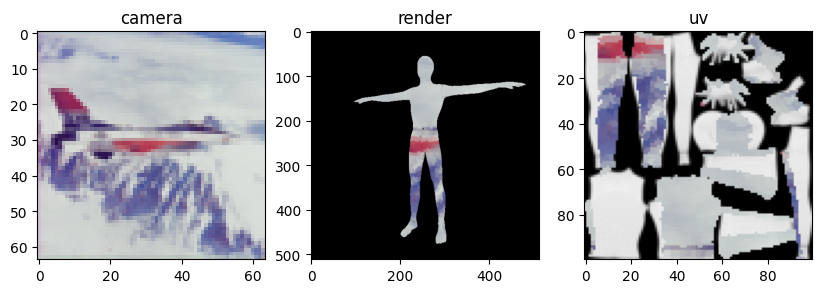

In [7]:
from text3d2video.rendering import make_mesh_renderer, make_repeated_uv_texture

meshes.textures = make_repeated_uv_texture(updated_texture, faces_uvs, verts_uvs)

renderer = make_mesh_renderer(cameras=cam, resolution=512)
frames = renderer(meshes)

fig, axs = plt.subplots(1, 3, figsize=(10, 5))

ax_cam = axs[0]
ax_render = axs[1]
ax_uv = axs[2]


ax_render.set_title("render")
ax_render.imshow(TF.to_pil_image(frames[0].cpu()))

ax_cam.set_title("camera")
ax_cam.imshow(camera_image.cpu())

ax_uv.set_title("uv")
ax_uv.imshow(updated_texture.cpu())

# Precomputing Rasterization

In [8]:
module_paths = [
    # "down_blocks.0.attentions.0.transformer_blocks.0.attn1",
    # "down_blocks.0.attentions.1.transformer_blocks.0.attn1",
    # "down_blocks.1.attentions.0.transformer_blocks.0.attn1",
    # "down_blocks.1.attentions.1.transformer_blocks.0.attn1",
    # "down_blocks.2.attentions.0.transformer_blocks.0.attn1",
    # "down_blocks.2.attentions.1.transformer_blocks.0.attn1",
    "mid_block.attentions.0.transformer_blocks.0.attn1",
    "up_blocks.1.attentions.0.transformer_blocks.0.attn1",
    "up_blocks.1.attentions.1.transformer_blocks.0.attn1",
    "up_blocks.1.attentions.2.transformer_blocks.0.attn1",
    "up_blocks.2.attentions.0.transformer_blocks.0.attn1",
    "up_blocks.2.attentions.1.transformer_blocks.0.attn1",
    "up_blocks.2.attentions.2.transformer_blocks.0.attn1",
    "up_blocks.3.attentions.0.transformer_blocks.0.attn1",
    "up_blocks.3.attentions.1.transformer_blocks.0.attn1",
    "up_blocks.3.attentions.2.transformer_blocks.0.attn1",
]

In [9]:
from text3d2video.artifacts.anim_artifact import AnimationArtifact

anim = AnimationArtifact.from_wandb_artifact_tag("handstand:latest")
frame_indices = anim.frame_indices(20)
cams, meshes = anim.load_frames(frame_indices)

anim_verts_uvs, anim_faces_uvs = anim.uv_data()

In [10]:
from text3d2video.rendering import precompute_rasterization


fragments = dict()

screen_resolutions = [8, 16, 32, 64]
render_resolutions = [8, 16, 32, 64]
texture_resolutions = [screen_res * 5 for screen_res in screen_resolutions]

projections, fragments = precompute_rasterization(
    cams,
    meshes,
    anim_verts_uvs,
    anim_faces_uvs,
    screen_resolutions,
    texture_resolutions,
)

In [11]:
from text3d2video.rendering import precompute_rast_fragments


render_resolutions = [8, 16, 32, 64]

fragments = precompute_rast_fragments(cams, meshes, render_resolutions)

In [12]:
type(fragments[0][0])

pytorch3d.renderer.mesh.rasterizer.Fragments

In [15]:
from text3d2video.rendering import TextureShader, shade_meshes, make_repeated_uv_texture


shader = TextureShader()
texture = make_repeated_uv_texture(updated_texture, anim_faces_uvs, anim_verts_uvs)

render_indices = [0, 1, 2, 3, 5, 6]
chunk_meshes = [meshes[i] for i in render_indices]
chunk_frags = [fragments[0][i] for i in render_indices]

renders = shade_meshes(shader, texture, chunk_meshes, chunk_frags)

renders.shape

torch.Size([6, 3, 8, 8])

: 

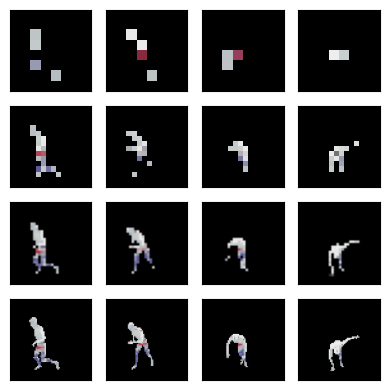

In [ ]:
from torch import Tensor
from text3d2video.rendering import TextureShader
from text3d2video.utilities.ipython_utils import display_ims_grid


def render_frames(meshes, uv_map, fragments):
    shader = TextureShader()
    texture = make_repeated_uv_texture(uv_map, anim_faces_uvs, anim_verts_uvs)

    rendered_frames = []
    for mesh, frags in zip(meshes, fragments):
        render_mesh = mesh.clone()
        render_mesh.textures = texture
        rendered = shader(frags, render_mesh)[0]
        rendered_frames.append(rendered)

    rendered_frames = torch.stack(rendered_frames)
    return rendered_frames


render_indices = Tensor([0, 1, 2, 3]).long()
render_meshes = meshes[render_indices]

all_renders_pil = []
for resolution_index in range(4):
    render_frags = [
        fragments[frame_idx][resolution_index] for frame_idx in render_indices.tolist()
    ]

    renders = render_frames(render_meshes, updated_texture, render_frags)
    renders_pil = [TF.to_pil_image(r.cpu()) for r in renders]
    all_renders_pil.append(renders_pil)

display_ims_grid(all_renders_pil, scale=1)

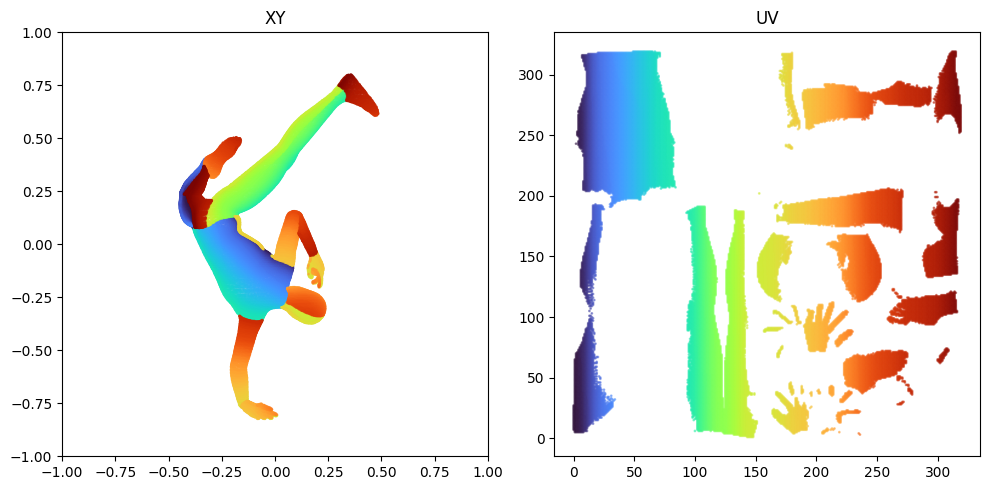

In [ ]:
projection = projections[9][3]

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
ax_xy = axs[0]
ax_uv = axs[1]
plot_projection(projection, ax_xy, ax_uv, s=1)